In [1]:
import pandas as pd 


In [2]:
data_fin = pd.read_csv('data_fin.csv') 

In [3]:
data_fin.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Years,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who_completed_the_test,ASD_traits
0,1,1,1,1,0,0,1,1,0,0,26.0,F,White-European,No,No,Self,No
1,1,1,0,1,0,0,0,1,0,1,24.0,M,Latino,No,Yes,Self,No
2,1,1,0,1,1,0,1,1,1,1,27.0,M,Latino,Yes,Yes,Parent,Yes
3,1,1,0,1,0,0,1,1,0,1,35.0,F,White-European,No,Yes,Self,No
4,1,0,0,0,0,0,0,1,0,0,40.0,F,?,No,No,?,No


In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
import matplotlib.pyplot as plt
import numpy as np

# 1. Preprocessing
y = data_fin['ASD_traits']
le = LabelEncoder()
y = le.fit_transform(y)

X = data_fin.drop(columns=['ASD_traits'])
categorical_cols = ['Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD', 'Who_completed_the_test']
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

scaler = StandardScaler()
numerical_cols = ['Age_Years'] + [f'A{i}' for i in range(1, 11)]
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (Linear Kernel)": SVC(kernel='linear', probability=True),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "Neural Network (MLP)": MLPClassifier(max_iter=500)
}

# Optional: Stacked Ensemble (using Logistic Regression as a meta-model)
estimators = [
    ('rf', RandomForestClassifier()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('lgbm', LGBMClassifier())
]
models["Stacked Ensemble"] = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# 3. Train and Evaluate Models (Track accuracy, loss, and feature importance)

def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    
    # Create folder to save graphs for each model
    os.makedirs(f"model_graphs/{model_name}", exist_ok=True)

    if hasattr(model, "fit"):
        # Track loss for MLPClassifier
        if isinstance(model, MLPClassifier):
            for epoch in range(500):  # Limit max iterations for plotting
                model.fit(X_train, y_train)
                train_accuracy = model.score(X_train, y_train)
                test_accuracy = model.score(X_test, y_test)
                train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)
                # Capture the loss at the current epoch (for MLPClassifier)
                train_losses.append(model.loss_)
            
            # Plot accuracy graph
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy")
            plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label="Testing Accuracy")
            plt.title(f'{model_name} Accuracy Over Epochs')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.savefig(f"model_graphs/{model_name}/accuracy_graph.png")
            plt.close()

            # Plot loss function graph
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
            plt.title(f'{model_name} Loss Over Epochs')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.savefig(f"model_graphs/{model_name}/loss_graph.png")
            plt.close()
        else:
            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            train_accuracy = accuracy_score(y_train, y_pred_train)
            test_accuracy = accuracy_score(y_test, y_pred_test)

            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)

            # Plot accuracy graph
            plt.figure(figsize=(10, 6))
            plt.plot(train_accuracies, label="Training Accuracy")
            plt.plot(test_accuracies, label="Testing Accuracy")
            plt.title(f'{model_name} Accuracy Over Epochs')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.savefig(f"model_graphs/{model_name}/accuracy_graph.png")
            plt.close()

        # Plot feature importance graph (for models that support it)
        if hasattr(model, 'feature_importances_'):
            feature_importance = model.feature_importances_
            feature_names = X.columns
            sorted_idx = np.argsort(feature_importance)[::-1]
            plt.figure(figsize=(10, 6))
            plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx])
            plt.title(f'{model_name} Feature Importance')
            plt.xlabel('Importance')
            plt.ylabel('Features')
            plt.tight_layout()
            plt.savefig(f"model_graphs/{model_name}/feature_importance.png")
            plt.close()

    return train_accuracies, test_accuracies

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    train_accuracies, test_accuracies = train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name=name)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name}: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    results[name] = accuracy

# 4. Compare Results
print("\nModel Performance Summary:")
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")


Training Logistic Regression...
Accuracy for Logistic Regression: 0.8104
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       362
           1       0.84      0.79      0.81       387

    accuracy                           0.81       749
   macro avg       0.81      0.81      0.81       749
weighted avg       0.81      0.81      0.81       749

Training SVM (Linear Kernel)...
Accuracy for SVM (Linear Kernel): 0.8491
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       362
           1       0.90      0.79      0.84       387

    accuracy                           0.85       749
   macro avg       0.85      0.85      0.85       749
weighted avg       0.86      0.85      0.85       749

Training SVM (RBF Kernel)...
Accuracy for SVM (RBF Kernel): 0.9012
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       362
           1       0.89 

/var/home/ujjain/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [06:16:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for XGBoost: 0.9706
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       362
           1       0.97      0.97      0.97       387

    accuracy                           0.97       749
   macro avg       0.97      0.97      0.97       749
weighted avg       0.97      0.97      0.97       749

Training LightGBM...
[LightGBM] [Info] Number of positive: 1604, number of negative: 1390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 2994, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535738 -> initscore=0.143197
[LightGBM] [Info] Start training from score 0.143197
Accuracy for LightGBM: 0.9680
              precision    recall  f1-sco

/var/home/ujjain/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [07:34:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1604, number of negative: 1390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 2994, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535738 -> initscore=0.143197
[LightGBM] [Info] Start training from score 0.143197


/var/home/ujjain/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [07:35:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/var/home/ujjain/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [07:36:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/var/home/ujjain/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [07:37:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/var/home/ujjain/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [07:38:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/var/home/ujjain/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [07:38:49] WA

[LightGBM] [Info] Number of positive: 1283, number of negative: 1112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 111
[LightGBM] [Info] Number of data points in the train set: 2395, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535699 -> initscore=0.143041
[LightGBM] [Info] Start training from score 0.143041
[LightGBM] [Info] Number of positive: 1283, number of negative: 1112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 2395, number of used features: 16
[LightGBM] [Info] [binary:Bo

# Supervised learning methods


# Deep Leaning Algorithms 

In [19]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# 1. Preprocessing
y = data_fin['ASD_traits']
le = LabelEncoder()
y = le.fit_transform(y)

X = data_fin.drop(columns=['ASD_traits'])
categorical_cols = ['Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD', 'Who_completed_the_test']
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

scaler = StandardScaler()
numerical_cols = ['Age_Years'] + [f'A{i}' for i in range(1, 11)]
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 2. Define Deep Learning Models

# 2.1 Define DNN Model
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 2.2 Define LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])  # Use the last hidden state
        return out

# 2.3 Define Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_size),
            nn.Sigmoid()  # To output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 2.4 Define CNN Model
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * (input_size - 2) // 2, output_size)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        return x

# 3. Train and Evaluate Models

# Function to train and evaluate a model, track metrics and save graphs
def train_and_evaluate(model, X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, epochs=200, batch_size=64, lr=0.001, model_name="model"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # To track training accuracy, testing accuracy, and loss for plotting
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    
    # Create folder to save graphs for each model
    os.makedirs(f"model_graphs/{model_name}", exist_ok=True)

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        train_losses.append(loss.item())
        _, train_predicted = torch.max(outputs, 1)
        train_accuracy = accuracy_score(y_train_tensor, train_predicted)
        train_accuracies.append(train_accuracy)
        
        # Track testing accuracy
        model.eval()
        with torch.no_grad():
            outputs = model(X_test_tensor)
            _, test_predicted = torch.max(outputs, 1)
            test_accuracy = accuracy_score(y_test_tensor, test_predicted)
            test_accuracies.append(test_accuracy)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # Plot accuracy graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy")
    plt.plot(range(1, epochs + 1), test_accuracies, label="Testing Accuracy")
    plt.title(f'{model_name} Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"model_graphs/{model_name}/accuracy_graph.png")
    plt.close()

    # Plot loss function graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
    plt.title(f'{model_name} Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"model_graphs/{model_name}/loss_graph.png")
    plt.close()

    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = accuracy_score(y_test_tensor, predicted)
        print(f"Final Accuracy: {accuracy:.4f}")
        print(classification_report(y_test_tensor, predicted))

# 3.1 Train and evaluate DNN model
print("Training DNN model...")
dnn_model = DNN(input_size=X_train.shape[1], hidden_size=128, output_size=len(le.classes_))
train_and_evaluate(dnn_model, X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, model_name="DNN")

# 3.2 Train and evaluate LSTM model (for sequential data)
# Reshape data for LSTM (add sequence dimension)
X_train_lstm = X_train_tensor.unsqueeze(1)  # Add a sequence dimension
X_test_lstm = X_test_tensor.unsqueeze(1)

print("Training LSTM model...")
lstm_model = LSTM(input_size=X_train.shape[1], hidden_size=128, output_size=len(le.classes_))
train_and_evaluate(lstm_model, X_train_lstm, X_test_lstm, y_train_tensor, y_test_tensor, model_name="LSTM")


# 3.3 Train and evaluate Autoencoder model
print("Training Autoencoder model...")
autoencoder_model = Autoencoder(input_size=X_train.shape[1])
train_and_evaluate(autoencoder_model, X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, model_name="Autoencoder")

# 3.4 Train and evaluate CNN model
# Reshape data for CNN (add channel dimension)
X_train_cnn = X_train_tensor.unsqueeze(1)  # Add a channel dimension
X_test_cnn = X_test_tensor.unsqueeze(1)

print("Training CNN model...")
cnn_model = CNN(input_size=X_train.shape[1], output_size=len(le.classes_))
train_and_evaluate(cnn_model, X_train_cnn, X_test_cnn, y_train_tensor, y_test_tensor, model_name="CNN")


Training DNN model...
Epoch [5/200], Loss: 1.4739, Train Accuracy: 0.5848, Test Accuracy: 0.5527
Epoch [10/200], Loss: 0.9679, Train Accuracy: 0.5698, Test Accuracy: 0.5594
Epoch [15/200], Loss: 0.6951, Train Accuracy: 0.7021, Test Accuracy: 0.7250
Epoch [20/200], Loss: 0.5389, Train Accuracy: 0.8417, Test Accuracy: 0.8425
Epoch [25/200], Loss: 0.4431, Train Accuracy: 0.8303, Test Accuracy: 0.8331
Epoch [30/200], Loss: 0.3930, Train Accuracy: 0.8360, Test Accuracy: 0.8545
Epoch [35/200], Loss: 0.3665, Train Accuracy: 0.8437, Test Accuracy: 0.8505
Epoch [40/200], Loss: 0.3478, Train Accuracy: 0.8407, Test Accuracy: 0.8411
Epoch [45/200], Loss: 0.3314, Train Accuracy: 0.8410, Test Accuracy: 0.8398
Epoch [50/200], Loss: 0.3150, Train Accuracy: 0.8387, Test Accuracy: 0.8371
Epoch [55/200], Loss: 0.2984, Train Accuracy: 0.8434, Test Accuracy: 0.8371
Epoch [60/200], Loss: 0.2822, Train Accuracy: 0.8470, Test Accuracy: 0.8438
Epoch [65/200], Loss: 0.2639, Train Accuracy: 0.8554, Test Accuracy

# Visualization 

/tmp/ipykernel_733946/3308350319.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')


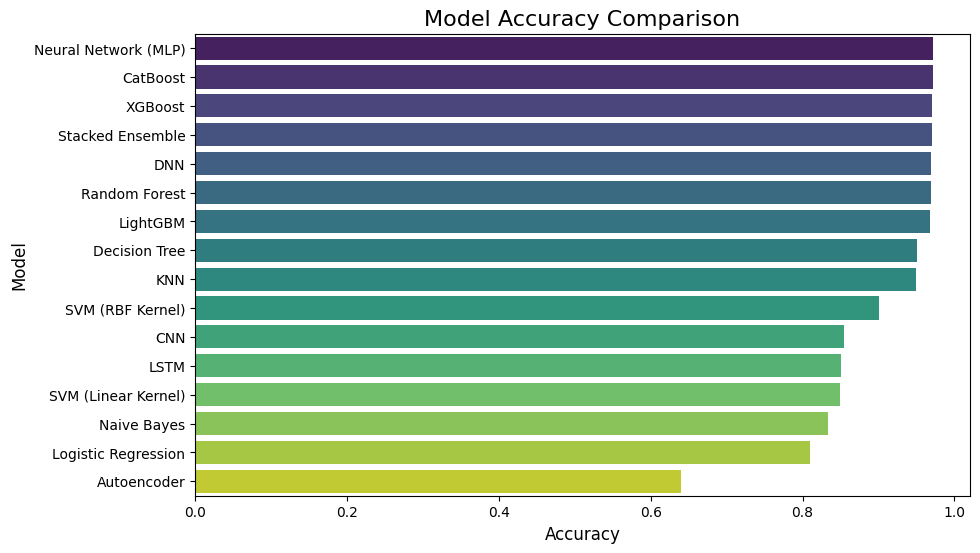

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Updated accuracy values
results = {
    "Logistic Regression": 0.8104,
    "SVM (Linear Kernel)": 0.8491,
    "SVM (RBF Kernel)": 0.9012,
    "Random Forest": 0.9693,
    "Decision Tree": 0.9506,
    "KNN": 0.9493,
    "Naive Bayes": 0.8331,
    "XGBoost": 0.9706,
    "LightGBM": 0.9680,
    "CatBoost": 0.9720,
    "Neural Network (MLP)": 0.9720,
    "Stacked Ensemble": 0.9706,
    "DNN": 0.9693,
    "LSTM": 0.8505,
    "Autoencoder": 0.6395,
    "CNN": 0.8545
}

# Create a dataframe from the results dictionary
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])

# Sort the dataframe based on accuracy
results_df = results_df.sort_values(by='Accuracy', ascending=False)

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')

# Add titles and labels
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Model', fontsize=12)

# Display the plot
plt.show()


# top 5 models - MLP, Catboost, XGboost, stacked ensemble, dnn 

# 1. catboost 


# 1 CatBoost 

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier

# Preprocessing
y = data_fin['ASD_traits']
le = LabelEncoder()
y = le.fit_transform(y)

X = data_fin.drop(columns=['ASD_traits'])
categorical_cols = ['Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD', 'Who_completed_the_test']
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

scaler = StandardScaler()
numerical_cols = ['Age_Years'] + [f'A{i}' for i in range(1, 11)]
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and Train CatBoost Model
catboost_model = CatBoostClassifier(verbose=100, eval_metric="Accuracy", use_best_model=True)
catboost_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test)
)

# Predictions
y_pred_train = catboost_model.predict(X_train)
y_pred_test = catboost_model.predict(X_test)

# Evaluate the Model
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"CatBoost Training Accuracy: {train_accuracy:.4f}")
print(f"CatBoost Testing Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Extract Training and Validation Metrics
evals_result = catboost_model.get_evals_result()
train_accuracy_over_iterations = evals_result['learn']['Accuracy']
test_accuracy_over_iterations = evals_result['validation']['Accuracy']
train_loss = evals_result['learn']['Logloss']
test_loss = evals_result['validation']['Logloss']

# Create output directory
os.makedirs("model_graphs/CatBoost", exist_ok=True)

# Plot Training and Testing Accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy_over_iterations, label="Training Accuracy")
plt.plot(test_accuracy_over_iterations, label="Testing Accuracy")
plt.title("CatBoost Training and Testing Accuracy Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("model_graphs/CatBoost/accuracy_graph.png")
plt.close()

# Plot Loss Function
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training Loss")
plt.plot(test_loss, label="Testing Loss")
plt.title("CatBoost Training and Testing Loss Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Logloss")
plt.legend()
plt.tight_layout()
plt.savefig("model_graphs/CatBoost/loss_graph.png")
plt.close()

# Feature Importance
feature_importance = catboost_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)[::-1]

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx])
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.savefig("model_graphs/CatBoost/feature_importance.png")
plt.close()


Learning rate set to 0.041547
0:	learn: 0.8670675	test: 0.8638184	best: 0.8638184 (0)	total: 3.15ms	remaining: 3.14s
100:	learn: 0.9886440	test: 0.9572764	best: 0.9586115 (80)	total: 260ms	remaining: 2.31s
200:	learn: 0.9963260	test: 0.9692924	best: 0.9706275 (196)	total: 492ms	remaining: 1.96s
300:	learn: 0.9979960	test: 0.9746328	best: 0.9759680 (272)	total: 727ms	remaining: 1.69s
400:	learn: 0.9979960	test: 0.9746328	best: 0.9759680 (272)	total: 960ms	remaining: 1.43s
500:	learn: 0.9979960	test: 0.9746328	best: 0.9759680 (272)	total: 1.21s	remaining: 1.21s
600:	learn: 0.9979960	test: 0.9746328	best: 0.9759680 (272)	total: 1.48s	remaining: 980ms
700:	learn: 0.9986640	test: 0.9746328	best: 0.9759680 (272)	total: 1.72s	remaining: 735ms
800:	learn: 0.9986640	test: 0.9746328	best: 0.9759680 (272)	total: 1.98s	remaining: 491ms
900:	learn: 0.9986640	test: 0.9759680	best: 0.9773031 (886)	total: 2.22s	remaining: 244ms
999:	learn: 0.9986640	test: 0.9773031	best: 0.9773031 (886)	total: 2.49s	r

# 2. XG Boost

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# Preprocessing
y = data_fin['ASD_traits']
le = LabelEncoder()
y = le.fit_transform(y)

X = data_fin.drop(columns=['ASD_traits'])
categorical_cols = ['Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD', 'Who_completed_the_test']
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

scaler = StandardScaler()
numerical_cols = ['Age_Years'] + [f'A{i}' for i in range(1, 11)]
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and Train XGBoost Model
xgboost_model = XGBClassifier(
    n_estimators=200,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgboost_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

# Predictions
y_pred_train = xgboost_model.predict(X_train)
y_pred_test = xgboost_model.predict(X_test)

# Evaluate the Model
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"XGBoost Training Accuracy: {train_accuracy:.4f}")
print(f"XGBoost Testing Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Extract Training and Validation Metrics
results = xgboost_model.evals_result()
train_loss = results['validation_0']['logloss']
test_loss = results['validation_1']['logloss']

# Create output directory
os.makedirs("model_graphs/XGBoost", exist_ok=True)

# Plot Training and Testing Accuracy
plt.figure(figsize=(10, 6))
plt.plot([1 - x for x in results['validation_0']['logloss']], label="Training Accuracy")
plt.plot([1 - x for x in results['validation_1']['logloss']], label="Testing Accuracy")
plt.title("XGBoost Training and Testing Accuracy Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("model_graphs/XGBoost/accuracy_graph.png")
plt.close()

# Plot Loss Function
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training Loss")
plt.plot(test_loss, label="Testing Loss")
plt.title("XGBoost Training and Testing Loss Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Logloss")
plt.legend()
plt.tight_layout()
plt.savefig("model_graphs/XGBoost/loss_graph.png")
plt.close()

# Feature Importance
feature_importance = xgboost_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)[::-1]

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx])
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.savefig("model_graphs/XGBoost/feature_importance.png")
plt.close()


[0]	validation_0-logloss:0.50836	validation_1-logloss:0.51653
[1]	validation_0-logloss:0.40197	validation_1-logloss:0.41752
[2]	validation_0-logloss:0.33509	validation_1-logloss:0.35156
[3]	validation_0-logloss:0.27499	validation_1-logloss:0.29613


/var/home/ujjain/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:35:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-logloss:0.23494	validation_1-logloss:0.26049
[5]	validation_0-logloss:0.20801	validation_1-logloss:0.23773
[6]	validation_0-logloss:0.18138	validation_1-logloss:0.21545
[7]	validation_0-logloss:0.16356	validation_1-logloss:0.19909
[8]	validation_0-logloss:0.14780	validation_1-logloss:0.18326
[9]	validation_0-logloss:0.13370	validation_1-logloss:0.17293
[10]	validation_0-logloss:0.12506	validation_1-logloss:0.16212
[11]	validation_0-logloss:0.11292	validation_1-logloss:0.15395
[12]	validation_0-logloss:0.10328	validation_1-logloss:0.14533
[13]	validation_0-logloss:0.09636	validation_1-logloss:0.14203
[14]	validation_0-logloss:0.08731	validation_1-logloss:0.13126
[15]	validation_0-logloss:0.08071	validation_1-logloss:0.12496
[16]	validation_0-logloss:0.07557	validation_1-logloss:0.11972
[17]	validation_0-logloss:0.06945	validation_1-logloss:0.11386
[18]	validation_0-logloss:0.06737	validation_1-logloss:0.11199
[19]	validation_0-logloss:0.06443	validation_1-logloss:0.1112

# 3. Stacked Ensemble 
    Base Models:

    Random Forest, XGBoost, and LightGBM are used as base models.
    Logistic Regression is used as the meta-model for stacking.


In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Preprocessing
y = data_fin['ASD_traits']
le = LabelEncoder()
y = le.fit_transform(y)

X = data_fin.drop(columns=['ASD_traits'])
categorical_cols = ['Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD', 'Who_completed_the_test']
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

scaler = StandardScaler()
numerical_cols = ['Age_Years'] + [f'A{i}' for i in range(1, 11)]
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Base Models
base_estimators = [
    ('rf', RandomForestClassifier()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('lgbm', LGBMClassifier())
]

# Define Stacked Ensemble
stacked_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression()
)

# Train the Stacked Ensemble
stacked_model.fit(X_train, y_train)

# Predictions
y_pred_train = stacked_model.predict(X_train)
y_pred_test = stacked_model.predict(X_test)

# Evaluate the Model
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Stacked Ensemble Training Accuracy: {train_accuracy:.4f}")
print(f"Stacked Ensemble Testing Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Plot Training and Testing Accuracy
# Create output directory
os.makedirs("model_graphs/Stacked_Ensemble", exist_ok=True)

# Generate Accuracy Graph
plt.figure(figsize=(10, 6))
plt.bar(["Training Accuracy", "Testing Accuracy"], [train_accuracy, test_accuracy], color=["blue", "orange"])
plt.title("Stacked Ensemble Training vs Testing Accuracy")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig("model_graphs/Stacked_Ensemble/accuracy_graph.png")
plt.close()

# Plot Feature Importances 
try:
    feature_importances = np.zeros(X.shape[1])
    for name, model in base_estimators:
        if hasattr(model, 'feature_importances_'):
            feature_importances += model.feature_importances_

    feature_names = X.columns
    sorted_idx = np.argsort(feature_importances)[::-1]

    # Normalize Feature Importances
    feature_importances /= len(base_estimators)

    # Plot Feature Importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
    plt.title("Stacked Ensemble Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.savefig("model_graphs/Stacked_Ensemble/feature_importance.png")
    plt.close()
except AttributeError:
    print("Feature importance is not available for one or more base models.")


/var/home/ujjain/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:02:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1604, number of negative: 1390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 2994, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535738 -> initscore=0.143197
[LightGBM] [Info] Start training from score 0.143197


/var/home/ujjain/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:02:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/var/home/ujjain/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:02:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/var/home/ujjain/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:02:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/var/home/ujjain/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:02:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/var/home/ujjain/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:02:58] WA

[LightGBM] [Info] Number of positive: 1283, number of negative: 1112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 111
[LightGBM] [Info] Number of data points in the train set: 2395, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535699 -> initscore=0.143041
[LightGBM] [Info] Start training from score 0.143041
[LightGBM] [Info] Number of positive: 1283, number of negative: 1112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 2395, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535699 -> initscore=0.143041
[LightGBM] [I

# 4. Random forest 

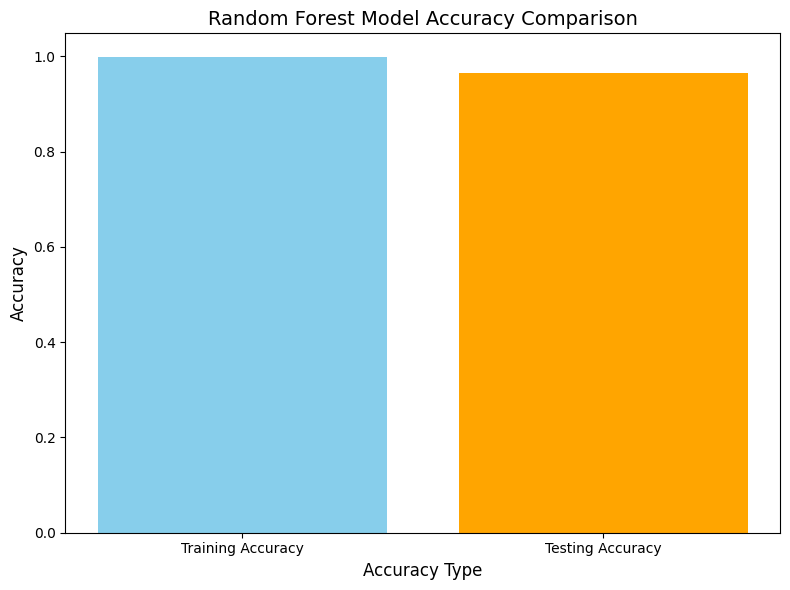

Accuracy for Random Forest (Training): 0.9987
Accuracy for Random Forest (Testing): 0.9653


In [23]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# 1. Preprocessing
y = data_fin['ASD_traits']
le = LabelEncoder()
y = le.fit_transform(y)

X = data_fin.drop(columns=['ASD_traits'])
categorical_cols = ['Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD', 'Who_completed_the_test']
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

scaler = StandardScaler()
numerical_cols = ['Age_Years'] + [f'A{i}' for i in range(1, 11)]
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Define Random Forest Model
rf_model = RandomForestClassifier()

# 3. Train the model and get accuracies
rf_model.fit(X_train, y_train)

# Track training and testing accuracies
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# 4. Create a Bar Graph for Accuracy
accuracies = [train_accuracy, test_accuracy]
accuracy_labels = ['Training Accuracy', 'Testing Accuracy']

# Ensure the directory exists
output_dir = "model_graphs/RandomForest"
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(8, 6))
plt.bar(accuracy_labels, accuracies, color=['skyblue', 'orange'])

# Adding titles and labels
plt.title('Random Forest Model Accuracy Comparison', fontsize=14)
plt.xlabel('Accuracy Type', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Display the bar chart
plt.tight_layout()
plt.savefig(f"{output_dir}/training_vs_testing_accuracy.png")
plt.show()

# Print Results
print(f"Accuracy for Random Forest (Training): {train_accuracy:.4f}")
print(f"Accuracy for Random Forest (Testing): {test_accuracy:.4f}")
